In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import os


# These numbers are mean and std values for channels of natural images. 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Inverse transformation: needed for plotting.
unnormalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

motion_transform_train = transforms.Compose([normalize])

content_transform_train = transforms.Compose([
                                    transforms.RandomResizedCrop(size=(160,240)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    normalize,
                                ])

class UnlabeledDataset(Dataset):
    def __init__(self, data_dir, num_frames=22, motion_transform=motion_transform_train):
        self.data_dir = data_dir
        self.motion_transform = motion_transform
        self.num_frames = num_frames
        self.video_list = []

        self.count = 0
        for vid_dir in os.listdir(self.data_dir):
            self.video_list.append(self.data_dir +"/"+vid_dir)
            self.count +=1
            
            if self.count == 2500:
                break

    def __len__(self):
        return self.count

    def __getitem__(self, idx):
        
        video_dir = self.video_list[idx]
        frame_list = []
        
        for i in range(self.num_frames):
            image = read_image(video_dir + "/" + "image_"+str(i)+".png")
            image = image/255.0
            
            if self.motion_transform:
                image = self.motion_transform(image)
            
            frame_list.append(image)  

        return frame_list

class LabeledDataset(Dataset):
    def __init__(self, data_dir, num_frames=22, motion_transform=motion_transform_train):
        self.data_dir = data_dir
        self.motion_transform = motion_transform
        self.num_frames = num_frames
        self.video_list = []

        self.count = 0
        for vid_dir in os.listdir(self.data_dir):
            self.video_list.append(self.data_dir +"/"+vid_dir)
            self.count +=1

    def __len__(self):
        return self.count

    def __getitem__(self, idx):
        
        video_dir = self.video_list[idx]
        frame_list = []
        
        for i in range(self.num_frames):
            image = read_image(video_dir + "/" + "image_"+str(i)+".png")
            image = image/255.0
            
            if self.motion_transform:
                image = self.motion_transform(image)
            
            frame_list.append(image)
        
        label = -1
        if os.path.isfile(video_dir+"/mask.npy"):
            try:
                label = np.load(video_dir+"/mask.npy")
            except:
                return None, None
        

        return frame_list, label

In [4]:
unlabeled_data = UnlabeledDataset("/dataset/dataset/unlabeled")
labeled_data = LabeledDataset("/dataset/dataset/train")
val_data = LabeledDataset("/dataset/dataset/val")


train_dataloader = DataLoader(unlabeled_data, batch_size=3, shuffle=True)
downstream_dataloader = DataLoader(labeled_data, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=1, shuffle=True)


# Hidden
# hidden_data = UnlabeledDataset("/content/drive/My Drive/Colab Notebooks/Spring23/DL/Project/hidden", 11)

# hidden_dataloader = DataLoader(hidden_data, batch_size=1, shuffle=True)

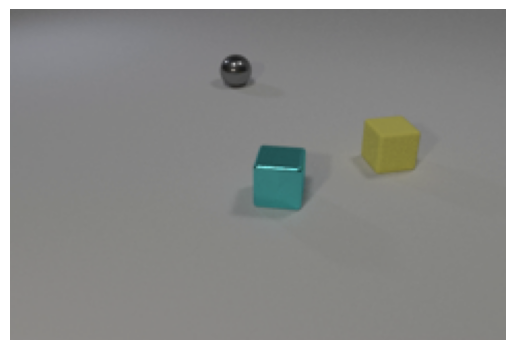

In [5]:
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100 # change dpi to make plots bigger

def show_normalized_image(img, title=None):
    plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0).numpy())
    plt.title(title)
    plt.axis('off')

show_normalized_image(unlabeled_data[10][0])

### Updated MC Jepa

In [6]:
def conv(in_features, out_features, kernel_size=3, stride=1, padding=1, dilation=1):   
    return nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel_size=kernel_size, stride=stride, 
                        padding=padding, dilation=dilation),
            nn.BatchNorm2d(out_features),
            nn.LeakyReLU(0.1))

def flow_cnn(in_features):
    return nn.Sequential(
            nn.Conv2d(in_features, 2, kernel_size=3, stride=1, 
                        padding=1),
            nn.BatchNorm2d(2),
            nn.LeakyReLU(0.1))


def deconv(in_planes, out_planes, kernel_size=4, stride=2, padding=1):
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size, stride, padding)

def corr4D(X_tnext, X_hat_tnext):
    batch_size, out_channels, ht, wd = X_tnext.shape
    X_tnext = X_tnext.view(batch_size, out_channels, ht*wd)
    X_hat_tnext = X_hat_tnext.view(batch_size, out_channels, ht*wd) 

    corr = torch.matmul(X_tnext.transpose(1,2), X_hat_tnext)
    corr = corr.view(batch_size, 1, ht*wd, ht*wd)
    corr = corr/torch.sqrt(torch.tensor(out_channels).float())
    correlation = corr

    mat_mul = torch.matmul(correlation, X_tnext.view(batch_size, out_channels, ht*wd, 1))
    mat_mul = mat_mul.view(batch_size, out_channels, ht, wd)
    
    return mat_mul
    

def warp(x, flo):
    """
    warp an image/tensor (im2) back to im1, according to the optical flow
    x: [B, C, H, W] (im2)
    flo: [B, 2, H, W] flow
    """

    B, C, H, W = x.size()
    # mesh grid 
    xx = torch.arange(0, W).view(1,-1).repeat(H,1)
    yy = torch.arange(0, H).view(-1,1).repeat(1,W)
    xx = xx.view(1,1,H,W).repeat(B,1,1,1)
    yy = yy.view(1,1,H,W).repeat(B,1,1,1)
    grid = torch.cat((xx,yy),1).float().to(device)

    if torch.is_tensor(flo): 
        vgrid = torch.autograd.Variable(grid) + flo
    else:
        vgrid = torch.autograd.Variable(grid)

    # scale grid to [-1,1] 
    vgrid[:,0,:,:] = 2.0*vgrid[:,0,:,:].clone() / max(W-1,1)-1.0
    vgrid[:,1,:,:] = 2.0*vgrid[:,1,:,:].clone() / max(H-1,1)-1.0

    vgrid = vgrid.permute(0,2,3,1)        
    output = nn.functional.grid_sample(x, vgrid)
    mask = torch.autograd.Variable(torch.ones(x.size())).to(device)
    mask = nn.functional.grid_sample(mask, vgrid)

    mask[mask<0.9999] = 0
    mask[mask>0] = 1
    return output*mask

In [7]:
class MCJepa(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        
        self.leakyRELU = nn.LeakyReLU(0.1)

        self.conv1 = conv(in_features, 4, 3, 2)
        self.conv1a = conv(4, 4, 3)
        self.conv1b = conv(4, 4, 3)
        self.conv1c = conv(4, 4, 3)

        self.conv1_0 = conv(4, 16, 3)
        self.conv1_1 = conv(32, 16, 3)
        self.conv1_2 = conv(48, 4, 3)
        self.conv1_3 = conv(52, 4, 3)
        
        self.flow_predictor1 = flow_cnn(4)
        self.deconv1 = deconv(2, 2)
        self.upfeat1 = deconv(4, 4)
        
        self.conv2 = conv(4, 8, 3, 2)
        self.conv2a = conv(8, 8, 3)
        self.conv2b = conv(8, 8, 3)
        self.conv2c = conv(8, 8, 3)

        self.conv2_0 = conv(8, 16, 3)
        self.conv2_1 = conv(24, 16, 3)
        self.conv2_2 = conv(40, 4, 3)
        self.conv2_3 = conv(44, 8, 3)
        
        self.flow_predictor2 = flow_cnn(8)
        self.deconv2 = deconv(2, 2)
        self.upfeat2 = deconv(8, 8)

        self.dc_conv0 = conv(4, 12, kernel_size=3, stride=1, padding=1,  dilation=1)
        self.dc_conv1 = conv(12, 16, kernel_size=3, stride=1, padding=2,  dilation=2)
        self.dc_conv2 = conv(16, 32, kernel_size=3, stride=1, padding=4,  dilation=4)
        self.dc_conv3 = conv(32, 64,  kernel_size=3, stride=1, padding=8,  dilation=8)

        self.refine_flow = flow_cnn(64)
        
        
    def forward(self, I_t, I_tnext): # , I_tcrop):
        
        X_t = None
        X_tnext = None
        X_hat_tnext = None
        X_hat_t = None
        f_t_tnext = None
        f_tnext_t = []
        
        # Image t downsampling
        I_t_x1 = self.conv1c(self.conv1b(self.conv1a(self.conv1(I_t))))
        I_t_x2 = self.conv2c(self.conv2b(self.conv2a(self.conv2(I_t_x1))))
        X_t = [I_t_x1, I_t_x2]
        
        # Image t+1 downsampling
        I_tnext_x1 = self.conv1c(self.conv1b(self.conv1a(self.conv1(I_tnext))))
        I_tnext_x2 = self.conv2c(self.conv2b(self.conv2a(self.conv2(I_tnext_x1))))
        X_tnext = [I_tnext_x1, I_tnext_x2]

        ### Image t -> t+1
        corr2 = corr4D(I_t_x2, I_tnext_x2)
        corr2 = self.leakyRELU(corr2)

        x = torch.cat((self.conv2_0(corr2), corr2), 1)
        x = torch.cat((self.conv2_1(x), x), 1)
        x = torch.cat((self.conv2_2(x), x), 1)
        x = self.conv2_3(x)
        
        flow2 = self.flow_predictor2(x)
        upflow2 = self.deconv2(flow2)
        upfeat2 = self.upfeat2(x)

        I_tnext_x1_hat = warp(I_t_x1, upflow2*0.625)
        corr1 = corr4D(I_tnext_x1_hat, I_tnext_x1)
        corr1 = self.leakyRELU(corr1)

        x = torch.cat((I_tnext_x1, self.conv1_0(corr1), corr1, upfeat2), 1)
        x = torch.cat((self.conv1_1(x), x), 1)
        x = torch.cat((self.conv1_2(x), x), 1)
        x = self.conv1_3(x)

        flow1 = self.flow_predictor1(x)
        upflow1 = self.deconv1(flow1)
        upfeat1 = self.upfeat1(x)

        # Refining flow
        x = self.dc_conv3(self.dc_conv2(self.dc_conv1(self.dc_conv0(upfeat1))))
        upflow1 = upflow1 + self.refine_flow(x)

        I_tnext_hat = warp(I_t, upflow1*1.25)
        X_hat_tnext = [I_tnext_x1_hat]
        f_t_tnext = [flow1, flow2]
        
        ### Image t+1 -> t

        rcorr2 = corr4D(I_tnext_x2, I_t_x2)
        rcorr2 = self.leakyRELU(rcorr2)

        x = torch.cat((self.conv2_0(rcorr2), rcorr2), 1)
        x = torch.cat((self.conv2_1(x), x), 1)
        x = torch.cat((self.conv2_2(x), x), 1)
        x = self.conv2_3(x)
        
        rev_flow2 = self.flow_predictor2(x)
        rev_upflow2 = self.deconv2(rev_flow2)
        rev_upfeat2 = self.upfeat2(x)

        I_t_x1_hat = warp(I_tnext_x1, rev_upflow2*0.625)
        rcorr1 = corr4D(I_t_x1_hat, I_t_x1)
        rcorr1 = self.leakyRELU(rcorr1)

        x = torch.cat((I_t_x1, self.conv1_0(rcorr1), rcorr1, rev_upfeat2), 1)
        x = torch.cat((self.conv1_1(x), x), 1)
        x = torch.cat((self.conv1_2(x), x), 1)
        x = self.conv1_3(x)

        rev_flow1 = self.flow_predictor1(x)
        rev_upflow1 = self.deconv1(rev_flow1)
        rev_upfeat1 = self.upfeat1(x)

        # Refining flow
        x = self.dc_conv3(self.dc_conv2(self.dc_conv1(self.dc_conv0(rev_upfeat1))))
        rev_upflow1 = rev_upflow1 + self.refine_flow(x)
        
        I_t_hat = warp(I_tnext, rev_upflow1*1.25)
        X_hat_t = [I_t_x1_hat]
        f_tnext_t = [rev_flow1, rev_flow2]
        
        return X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext, f_tnext_t, I_t_hat, I_tnext_hat, upflow1
    

In [8]:
# a = torch.zeros([1, 3, 160, 240]).to(device)
# b = torch.zeros([1, 3, 160, 240]).to(device)

# mcmodel = MCJepa(3).to(device)
# mcmodel(a, b)


In [9]:
def off_diagonal(M):
    res = M.clone()
    res.diagonal(dim1=-1, dim2=-2).zero_()
    return res

def vc_reg(X_t, X_tnext, lm, mu, nu):
    N = X_t.shape[0]
    C = X_t.shape[1]
    H = X_t.shape[2]
    W = X_t.shape[3] 
    D = C + H + W 
    mse_loss = nn.MSELoss()
    sim_loss = mse_loss(X_t, X_tnext)
    
    std_z_a = torch.sqrt(X_t.var(dim=0) + 1e-04)
    std_z_b = torch.sqrt(X_tnext.var(dim=0) + 1e-04)
    std_loss = torch.mean(F.relu(1-std_z_a)) + torch.mean(F.relu(1-std_z_b))

    X_t = X_t - X_t.mean(dim=0)
    X_tnext = X_tnext - X_tnext.mean(dim=0)
    cov_z_a = torch.matmul(X_t.view(N, C, W, H), X_t)/ (N-1)
    cov_z_b = torch.matmul(X_tnext.view(N, C, W, H), X_tnext)/ (N-1)
    conv_loss = (off_diagonal(cov_z_a).pow_(2).sum()/D) + (off_diagonal(cov_z_b).pow_(2).sum()/D) 
        
    loss = lm*sim_loss + mu*std_loss + nu*conv_loss
    return loss

def cycle_loss_fn(f_t_tnext, f_tnext_t, X_t, X_tnext, lambda_a, lambda_b):
    loss_cycle_A = torch.tensor(0.0).to(device)
    loss_cycle_B = torch.tensor(0.0).to(device)
    for i in range(1, len(X_t)):
        loss_cycle_A += F.l1_loss(warp(X_t[i], f_t_tnext[i]), X_tnext[i]) * lambda_a
        loss_cycle_B += F.l1_loss(warp(X_tnext[i], f_tnext_t[i]), X_t[i]) * lambda_b
        
    return loss_cycle_A + loss_cycle_B

In [10]:
def MCJepa_criterion(X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext, f_tnext_t, I_hat_t, I_hat_tnext, img1, img2, lm, mu, nu, lambda_a, lambda_b,show=False):
  
    mse_loss = nn.MSELoss()    
    rec_loss = nn.MSELoss()
    reg_loss = nn.MSELoss()
    
    regress_loss_forward = torch.tensor(0.0).to(device)
    regress_loss_backward = torch.tensor(0.0).to(device)
    for i in range(len(X_hat_tnext)):
        regress_loss_forward += reg_loss(X_hat_tnext[i], X_tnext[i])
        regress_loss_backward += reg_loss(X_hat_t[i], X_t[i])

    reconst_loss_forward = rec_loss(I_hat_tnext, img2)
    reconst_loss_backward = rec_loss(I_hat_t, img1)
    vc_reg_loss = torch.tensor(0.0).to(device)
    
    for i in range(len(X_t)):
        vc_reg_loss += vc_reg(X_t[i], X_tnext[i], lm, mu, nu)

    cycle_loss = cycle_loss_fn(f_t_tnext, f_tnext_t, X_t, X_tnext, lambda_a, lambda_b)
    
    # if show:
    #     print("regress_loss_forward: ",50*regress_loss_forward)
    #     print("regress_loss_backward: ",50*regress_loss_backward)
    #     print("reconst_loss_forward: ",1000*reconst_loss_forward)
    #     print("reconst_loss_backward: ",1000*reconst_loss_backward)
    #     print("vc_reg_loss: ",vc_reg_loss)
    #     print("cycle_loss: ",50*cycle_loss)

    #     print("\n\n")

    
    return 50*regress_loss_forward + 50*regress_loss_backward + 1000*reconst_loss_forward + 1000*reconst_loss_backward + 50*cycle_loss + vc_reg_loss 



In [11]:
from tqdm import tqdm

def train_MCJepa(model, epochs, dataloader, criterion, optimizer, model_name, frame_diff = 1, scheduler=None):
    model.train()

    train_losses = []

    best_loss = float("inf")
    best_model = model.state_dict()

    for e in range(epochs):
        total_train_loss = 0.0
        total_train_correct = 0.0
        
        pbar = tqdm(dataloader, leave=False)

        for j,batch in enumerate(pbar):
            if j == 1667: 
                break

            frame_list = batch
            total_train_loss = 0.0
            for i in range(len(frame_list) - frame_diff):
                img1 = frame_list[i].to(device)
                img2 = frame_list[i+frame_diff].to(device)
#                 print(img1.shape)
                X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext,\
                f_tnext_t, I_hat_t, I_hat_tnext, upflow1 = model(img1, img2)

                loss = criterion(X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext,\
                                f_tnext_t, I_hat_t, I_hat_tnext, img1, img2,\
                                lm, mu, nu, lambda_a, lambda_b,(i+21*j)%660 == 0)
            
                total_train_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # scheduler.step()
            
            pbar.set_postfix({'Video Loss': total_train_loss/(len(frame_list)-frame_diff)})

            if total_train_loss/(len(frame_list)-frame_diff) < best_loss:
                best_loss = total_train_loss/(len(frame_list)-frame_diff)
                best_model = model.state_dict()
                
            if j % 30 == 0 and j > 0:
                torch.save(best_model,"/content/drive/My Drive/Colab Notebooks/Spring23/DL/Project/best_"+model_name+".pth")
                pbar.set_postfix({'Video Loss': total_train_loss/(len(frame_list)-frame_diff), 'Saved model with loss': best_loss})
            
        pbar.set_postfix({'Per frame Loss': total_train_loss/(len(frame_list)-frame_diff), 'Saved model at j': j})
        torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/Spring23/DL/Project/"+model_name+".pth")

In [12]:
# Constants to figure out later
model_name = "model_Context_5ep"
in_features = 3 
lm, mu, nu, lambda_a, lambda_b = 0.02, 0.02, 0.01, 1, 1
frame_diff = 1

In [13]:
MCJepa_model = MCJepa(in_features).to(device)
optimizer = optim.SGD(MCJepa_model.parameters(),
                          lr=1e-5, foreach=True)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,5)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 1e-7, 1e-5, step_size_up=2)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataloader)*21, epochs=1)

In [14]:
# train_MCJepa(MCJepa_model, 5, train_dataloader, MCJepa_criterion, optimizer, model_name, frame_diff) # Training the MC JEPA

In [13]:
PATH = "best_"+model_name+".pth"
MCJepa_model = MCJepa(in_features).to(device)
MCJepa_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [16]:
# flow_1 = 0
# flow_2 = 0

In [17]:
# for batch in train_dataloader:
# #     MCJepa_model.reset_flows()
#     frame_list = batch
#     img1 = frame_list[0].to(device)
#     img2 = frame_list[1].to(device)

#     X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext,\
#                 f_tnext_t, I_hat_t, I_hat_tnext = MCJepa_model(img1, img2)

#     loss = MCJepa_criterion(X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext,\
#                     f_tnext_t, I_hat_t, I_hat_tnext, img1, img2,\
#                      lm, mu, nu, lambda_a, lambda_b)
    
#     print("Loss: ", loss.item())
# #     flow_1 = f_t_tnext
#     flow_2 = f_t_tnext
# #     print(f_t_tnext[0])
#     print((f_t_tnext[0] == 0).all())
    

#     show_normalized_image(img1[0])
#     plt.show()
#     show_normalized_image(I_hat_t[0])
#     plt.show()
#     show_normalized_image(img2[0])
#     plt.show()
#     show_normalized_image(I_hat_tnext[0])
#     plt.show()
#     show_normalized_image(torch.square(I_hat_t[0]-img2[0]))
#     plt.show()
#     show_normalized_image(torch.square(I_hat_tnext[0]-img1[0]))
#     plt.show()
#     show_normalized_image(torch.square(img2[0]-img1[0]))
    
# #     print(Y1)
#     break
    
    

### Downstream Task

In [14]:
MCJepa_model.eval()

MCJepa(
  (leakyRELU): LeakyReLU(negative_slope=0.1)
  (conv1): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (conv1a): Sequential(
    (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (conv1b): Sequential(
    (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (conv1c): Sequential(
    (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (conv1_0): Sequential(
    (0): Co

In [15]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()

        if not mid_channels:
            mid_channels = (out_channels + in_channels)//2
            
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
 
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, n_channels = 3, n_classes = 49, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [20]:
# def train_fine_tune(downstream_model, epochs, dataloader, criterion, optimizer):
#     downstream_model.train()

#     train_losses = []

#     best_loss = float("inf")
# #     best_model = {}
#     best_model = downstream_model.state_dict()

#     for _ in range(epochs):
#         total_train_loss = 0.0
#         total_train_correct = 0.0

#         pbar = tqdm(dataloader, leave=False)

#         for j, batch in enumerate(pbar):
          
#             if j == 333:
#                 break
                
#             frame_list, mask_list = batch[0], batch[1] # TODO
#             total_train_loss = 0.0
            

#             for i in range(len(frame_list) - 1):
#                 img1 = frame_list[i].to(device)
#                 img2 = frame_list[i+1].to(device)
#                 mask_list = mask_list.type(torch.LongTensor).to(device)


#                 logits = downstream_model(img1)
#                 loss = criterion(logits, mask_list[:,i])

#                 total_train_loss += loss.item()

#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#             pbar.set_postfix({'Per frame Loss': total_train_loss/(len(frame_list)-1)})

#             if total_train_loss/(len(frame_list)-1) < best_loss:
#                 best_loss = total_train_loss/(len(frame_list)-1)
#                 best_model = downstream_model.state_dict()

#             if j%25 == 0:
#                 torch.save(best_model,"best_downstream_model.pth")
#                 pbar.set_postfix({'Per frame Loss': total_train_loss/(len(frame_list)-1), 'Saved downstream model with loss': best_loss})
          
#         pbar.set_postfix({'Per frame Loss': total_train_loss/(len(frame_list)-1), 'Saved model at j': j})
#         torch.save(downstream_model.state_dict(), "downstream_model.pth")
          
#     torch.save(best_model,"best_downstream_model.pth")

In [16]:
# in_features_downstream = 16

# downstream_model = UNet().to(device)
# downstream_optimizer = optim.RMSprop(downstream_model.parameters(),
#                           lr=1e-5, weight_decay=1e-8, momentum=0.999, foreach=True)

criterion = nn.CrossEntropyLoss()

In [17]:
# train_fine_tune(downstream_model, 5, downstream_dataloader, criterion, downstream_optimizer)

In [18]:
PATH = "best_downstream_model.pth"
downstream_model = UNet().to(device)
downstream_model.load_state_dict(torch.load(PATH))
downstream_model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 33, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(33, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

In [19]:
!pip install torchmetrics
import torchmetrics

Defaulting to user installation because normal site-packages is not writeable


In [20]:
jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=49).to(device)

In [64]:
import scipy.ndimage as nd
from tqdm import tqdm
def real_test(downstream_model, JepaModel, OutputRefineModel, epochs, dataloader, criterion, scale = 0.1, r = 1):
    
    downstream_model.eval()
    JepaModel.eval()
    
    train_losses = []

    best_loss = float("inf")
    best_model = downstream_model.state_dict()


    final_submit = None
    mask_tensor = None
    for _ in range(epochs):
        total_train_loss = 0.0

        pbar = tqdm(dataloader, leave=False)
        
        avg_jacc = 0.0
        

        for j,batch in enumerate(pbar):
          
            frame_list, mask_list = batch[0], batch[1] # TODO
            total_train_loss = 0.0
            X_tconcat = None
            I_hat_t = None
            I_hat_tnext = None
            I_hat_t = None
            img11 = None  
            
            final_flow = 0.0
            for i in range(10):
                img1 = frame_list[i].to(device)
                img2 = frame_list[i+1].to(device)
                if i == 9:
                    img11 = img2
                mask_list = mask_list.type(torch.LongTensor).to(device)


                X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext,\
                f_tnext_t, I_hat_t, I_hat_tnext, upflow1 = JepaModel(img1, img2)
                final_flow = upflow1*1.25 + scale*final_flow

                
            
            mask_pred = downstream_model(frame_list[10].to(device))
            mask_pred_ = downstream_model(frame_list[10].to(device))
            
            img1 = None
            img2 = None
            for i in range(10):
                if i == 0:
                    img1 = img11
                
                img2 = warp(img1, upflow1*1.25)
                X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext,\
                    f_tnext_t, I_hat_t, I_hat_tnext, upflow1 = JepaModel(img1, img2)
                
                img1 = img2

                # print(f_t_tnext[0].shape, mask_pred.shape)
                # flow = upflow1*1.25
                mask_pred_ = warp(mask_pred_, upflow1*1.25)
#                 flow_np = (upflow1*1.25).cpu().detach().numpy()
#                 smoothed = torch.tensor(nd.gaussian_filter(flow_np, sigma=5,radius=(0,0,r,r))).to(device)
#                 mask_pred_ = warp(mask_pred_, smoothed)
            # mask_pred = downstream_model(img1)
            
            
            # final_flow *= 11
            # final_flow_np = final_flow.cpu().detach().numpy()
            # # smoothed = torch.tensor(nd.maximum_filter(final_flow_np, size=(1,1,r,r))).to(device)
            # final_flow = torch.tensor(nd.gaussian_filter(final_flow_np, sigma=5,radius=(0,0,r,r))).to(device)
            # mask_pred = warp(mask_pred, final_flow)

            # print(smoothed)

            # print(final_flow_np)

            # print(smoothed == final_flow)

            plt.imshow(unnormalize(img11[0]).detach().cpu().permute(1, 2, 0).numpy())
            plt.title("11th Frame")
            plt.show()
            plt.imshow(unnormalize(frame_list[21][0]).detach().cpu().permute(1, 2, 0).numpy())
            plt.title("22nd Frame")
            plt.show()
            plt.imshow(unnormalize(img1[0]).detach().cpu().permute(1, 2, 0).numpy())
            plt.title("Predicted 22nd Frame")
            plt.show()
            

            # print(f_t_tnext)
            # print(jaccard(mask_pred, mask_list[:,21]))
            # print((torch.argmax(mask_pred[0], dim=0) == torch.argmax(mask_pred_[0].cpu())).all())
            plt.imshow(torch.argmax(mask_pred_[0].cpu(), dim=0))
            plt.title("Predicted 11th Mask")
            plt.show()
            plt.imshow(mask_list[0][21].cpu())
            plt.title("22nd Mask")
            plt.show()
            plt.imshow(torch.argmax(mask_pred_[0].cpu(), dim=0))
            plt.title("Predicted 22nd Mask")
            plt.show()
            plt.imshow(torch.argmax(mask_pred[0].cpu(), dim=0))
            plt.title("Predicted 22nd Mask with refine")
            plt.show()

            avg_jacc += jaccard(mask_pred, mask_list[:,21])
            pbar.set_postfix({'Per frame Loss': total_train_loss/(len(frame_list)-1), 'avg_jaccard': avg_jacc.item() / (j+1)}) 


            # Calculate True Jaccard
#             mask_pred = torch.argmax(mask_pred[0], dim=0)
#             mask_pred = mask_pred.unsqueeze(0)
            
#             if final_submit is None:
#                 final_submit = mask_pred
#                 mask_tensor = mask_list[:,21]
#             else:
#                 final_submit = torch.cat([final_submit, mask_pred], dim=0)
#                 mask_tensor = torch.cat([mask_tensor, mask_list[:,21]], dim=0)

#             pbar.set_postfix({'Video': j+1}) 
#     print(jaccard(final_submit, mask_tensor))

In [ ]:
import matplotlib.pyplot as plt
real_test(downstream_model, MCJepa_model, OutputRefineModel, 1, val_dataloader, criterion, scale =0.0, r = 3)

In [ ]:
# a = torch.zeros([1, 1, 3, 3])
# # a = torch.nn.functional.pad(a, pad=(2, 2))
# postprocess = torch.nn.AvgPool2d(3, padding = 1)
# postprocess(a)

